# Demonstration of Crommelin model

In [60]:
import numpy as np
import matplotlib.pyplot as plt 
from os.path import join, exists
from os import makedirs
from pprint import pprint

from importlib import reload
import crommelin2004tracer; reload(crommelin2004tracer)


<module 'crommelin2004tracer' from '/orcd/home/001/ju26596/rare_event_simulation/TEAMS/examples/crommelin2004accelerated/crommelin2004tracer.py'>

This model comes from the paper https://journals.ametsoc.org/view/journals/atsc/61/12/1520-0469_2004_061_1406_amfarb_2.0.co_2.xml?tab_body=fulltext-display

## Define the model

Package the important parameters into a dictionary called ```cfg```, short for "config", which in turn is short for "configuration"

In [8]:
cfg = crommelin2004tracer.Crommelin2004TracerODE.default_config()
# Reduce the number of particles and cells for cheaper computation
cfg['Nparticles'] = 5 # how many particles to advect
cfg['Nxfv'] = 64 # number of sub-divisions of the x axis into control volumes
cfg['Nyfv'] = 16 # number of sub-divisions of the y axis into control volumes 
cfg['source_period'] = 1000.0
pprint(cfg)


{'C': 0.1,
 'Nparticles': 5,
 'Nxfv': 64,
 'Nyfv': 16,
 'b': 0.5,
 'beta': 1.25,
 'dt_plot': 0.25,
 'dt_save': 0.1,
 'dt_step': 0.025,
 'frc': {'impulsive': {'magnitudes': [0.01], 'modes': [5]},
         'type': 'impulsive'},
 'gamma_limits': [0.2, 0.2],
 'glob_diss_rate': 0.025,
 'r': -0.801,
 'source_amplitude': 0.25,
 'source_mean': 1.0,
 'source_period': 1000.0,
 'source_relative_width': 0.03125,
 't_burnin_phys': 10.0,
 'timestepper': 'monotone',
 'x1star': 0.95,
 'year_length': 400.0}


### param2vary: 
- (Nxfv,Nyfv)
- source_amplitude, source_mean, source_period

In [61]:
crom = crommelin2004tracer.Crommelin2004TracerODE(cfg) # subclass of ODESystem, which is a subclass of DynamicalSystem
print(f'dimensionality of system = {crom.state_dim}')

dimensionality of system = 1040


What is the dimensionality (a.k.a. degrees of freedom) of this system? __Exercise__: explain how this number is calculated, and find where it's done in the code. Report which method is harder ;) 

## Run the model

Make a directory to save output, by automatically generating a string that abbreviates all the important parameter choices made above.

In [62]:
abbrv,label = crommelin2004tracer.Crommelin2004TracerODE.label_from_config(cfg)
print(f'Abbreviation for directory naming = \n{abbrv}')

Abbreviation for directory naming = 
x1st0p95_r-0p801_src1pm0p25_sink0p025_gam0p2to0p2_frcimp_mode5_fvgrid64x16


In [63]:
savedir = join(
    "/pool001/ju26596/jesus_project/tracer_extremes_results/crommelin",
    "2024-11-06",
    abbrv
)
makedirs(savedir, exist_ok=True)
print(f'Results will be saved in the location \n{savedir}')

Results will be saved in the location 
/pool001/ju26596/jesus_project/tracer_extremes_results/crommelin/2024-11-06/x1st0p95_r-0p801_src1pm0p25_sink0p025_gam0p2to0p2_frcimp_mode5_fvgrid64x16


Initialize a run by specifying an initial condition ```state_init```, an initial time, and a terminal times. We specify these in *physical* units, denoted with ```tp```, but then convert to integer times via the fundamental time unit ```cfg['dt_save']```. 

__Exercise__: what do you think is the difference between the various ```dt_```s in the config dictionary? 

In [64]:
tp_init_ctrl = 0.0
tp_term_ctrl = 2000.0
t_init_ctrl = int(round(tp_init_ctrl/cfg['dt_save']))
t_term_ctrl = int(round(tp_term_ctrl/cfg['dt_save']))
t_ctrl = np.arange(t_init_ctrl+1,t_term_ctrl+1,step=1,dtype=int)
tp_ctrl = t_ctrl * crom.dt_save
Nt_ctrl = len(t_ctrl)
state_init_ctrl = crom.generate_default_init_cond(tp_init_ctrl)
tspan_str_ctrl = (f't{tp_init_ctrl}-{tp_term_ctrl}').replace('.','p')
state_file_ctrl = join(savedir,f'ctrl_{tspan_str_ctrl}.npz')

Run the following cell only if integrating for the first time.

In [16]:
state_ctrl = np.zeros((len(tp_ctrl),crom.state_dim))
integration_fun = getattr(crom, f'integrate_{cfg["timestepper"]}')
integration_fun(state_ctrl, tp_ctrl, t_init_ctrl, state_init_ctrl) # mutating function 
np.savez(state_file_ctrl, **{'t': t_ctrl, 'state': state_ctrl})

# Examine the output

In [65]:
history = np.load(state_file_ctrl)
t_ctrl = history['t']
state_ctrl = history['state']

In [66]:
# some observable functions for convenience
# sh stands for state_hist
def sf_fun(sh): # get streamfunction
    Nt = len(sh)
    x_s,y_s,basis_s,x_u,y_u,basis_u,x_v,y_v,basis_v,x_c,y_c = crom.basis_functions(Nx,Ny)
    psis = np.zeros((Nt,Nx+1,Ny+1))
    for i_comp in range(len(basis_s)):
        for i_t in range(Nt):
            psis[i_t] += basis_s[i_comp,:,:]*sh[i_t,i_comp]
    return psis
def conc_fun(sh): # get concentrations
    Nt = len(sh)
    Nx,Ny,Nparticles,flowdim = (crom.timestep_constants[key] for key in ['Nx','Ny','Nparticles','flowdim'])
    concs_gridded = sh[:,flowdim:flowdim+(Nx*Ny)].reshape((Nt,Nx,Ny))
    return concs_gridded
def posn_fun(sh):
    Nt = len(sh)
    Nx,Ny,Nparticles,flowdim = (crom.timestep_constants[key] for key in ['Nx','Ny','Nparticles','flowdim'])
    d = flowdim+Nx*Ny
    xs = sh[:,d:(d+Nparticles)]
    ys = sh[:,(d+Nparticles):(d+2*Nparticles)]
    return (xs,ys)
Lx = 2*np.pi
Ly = np.pi*cfg['b']
Nx = cfg['Nxfv']
Ny = cfg['Nyfv']
Nt = len(tp_ctrl)
dx = Lx/Nx
dy = Ly/Ny

The first part of the state vector is the streamfunction; the second part is the concentrations; and the last part is the particle trajectories. 

In [67]:
flowdim = 6 # how many numbers needed to specify the flow field 
concdim = cfg['Nxfv']*cfg['Nyfv']
xlagdim = cfg['Nparticles']
ylagdim = cfg['Nparticles']

sf_ctrl = sf_fun(state_ctrl)
conc_ctrl = conc_fun(state_ctrl)
posn_ctrl = posn_fun(state_ctrl)


Text(0.5, 1.0, 'Flow modes')

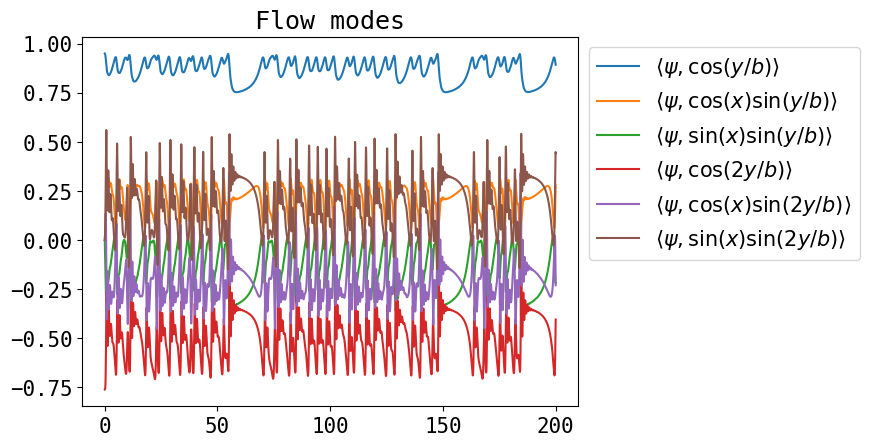

In [68]:
obslib = crom.observable_props()
basis_abbrvs = list(obslib.keys())

fig,ax = plt.subplots()
handles = []
for i in range(6):
    h, = ax.plot(tp_ctrl*crom.dt_save, state_ctrl[:,i], label=r"$\langle\psi,$%s$\rangle$"%(obslib[basis_abbrvs[i]]['label']))
    handles.append(h)
ax.legend(handles=handles,bbox_to_anchor=(1,1),loc='upper left')
ax.set_title("Flow modes")

We can visualize what these coefficients mean as maps.

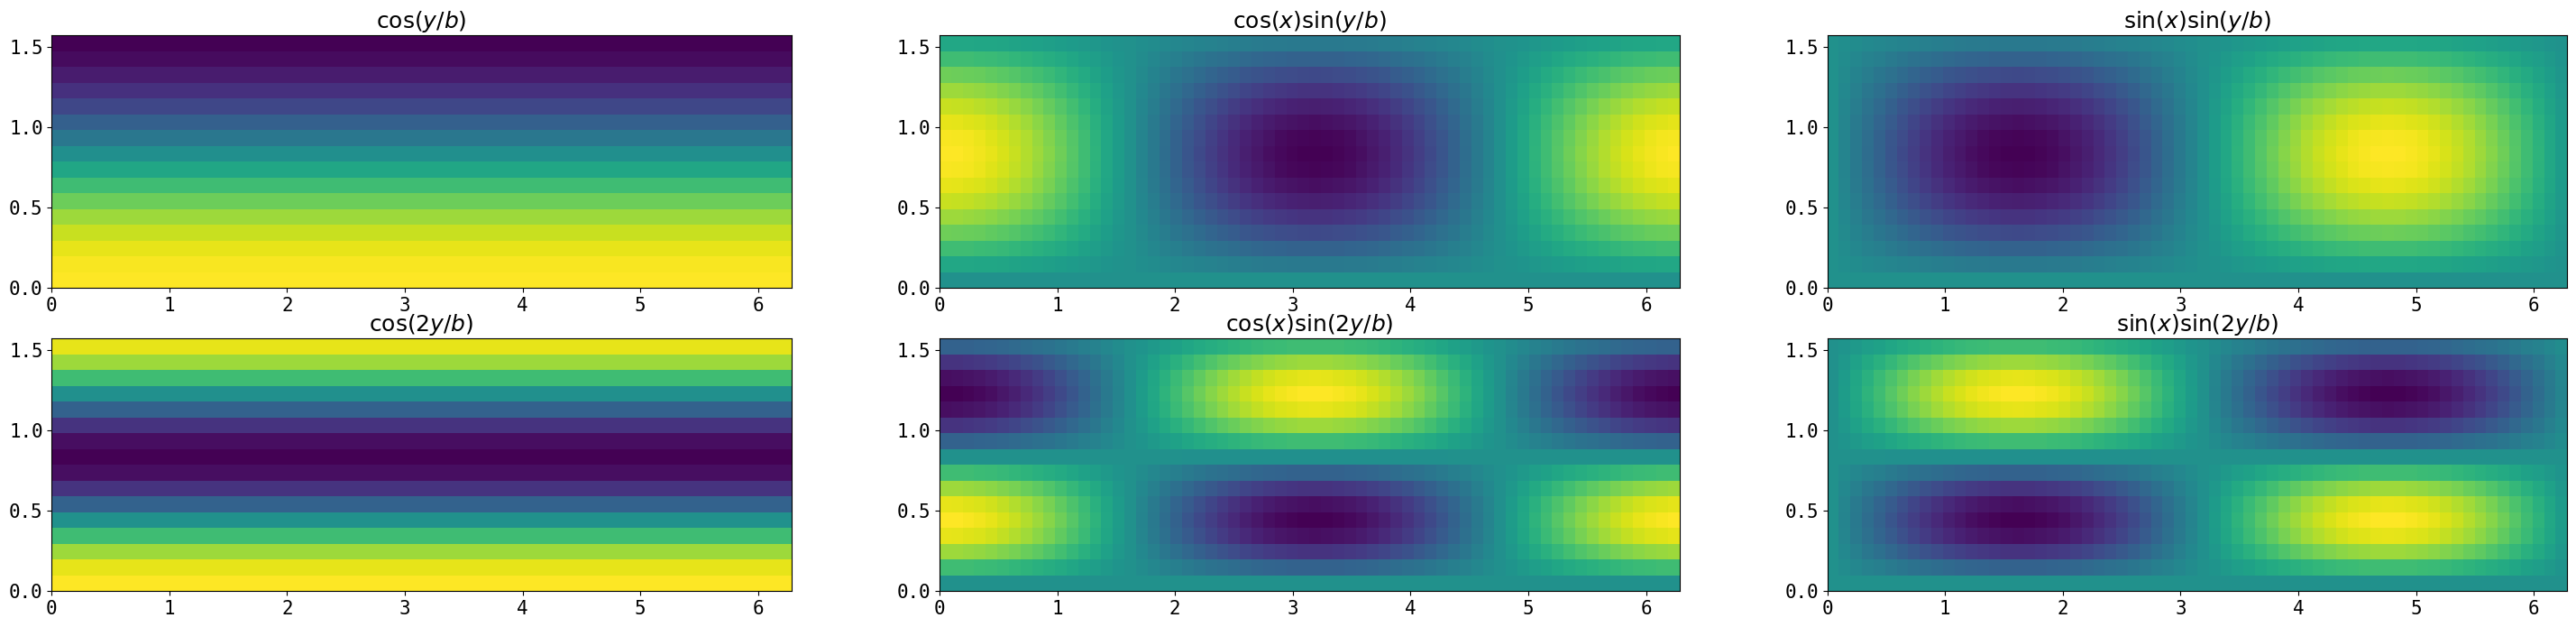

In [69]:
x_s,y_s,basis_s,x_u,y_u,basis_u,x_v,y_v,basis_v,x_c,y_c = crom.basis_functions(Nx,Ny)
fig,axes = plt.subplots(ncols=3,nrows=2,figsize=(36,8))
X,Y = np.meshgrid(x_s,y_s,indexing='ij')
for i_basis in range(6):
    ax = axes.flat[i_basis]
    ax.pcolormesh(X,Y,basis_s[i_basis,:-1,:-1])
    ax.set_title(obslib[basis_abbrvs[i_basis]]["label"])



Each of the timeseries above represents the coefficient multiplying the corresponding basis function. Adding them up according to that same linear combination, we obtain the full flow field. Below, we plot the flow field at a few different times.

In [70]:
tps2plot = np.array([0.0, 500.0, 570.0, 640.0, 710.0]) #210.0, 350.0])
idx2plot = (tps2plot/crom.dt_save).astype(int)
psis2plot = sf_fun(state_ctrl[idx2plot])
concs2plot = conc_fun(state_ctrl[idx2plot])
Nt2plot = len(tps2plot)

In [71]:
tps2plot = np.array([0.0, 500.0, 570.0, 640.0, 710.0]) #210.0, 350.0])

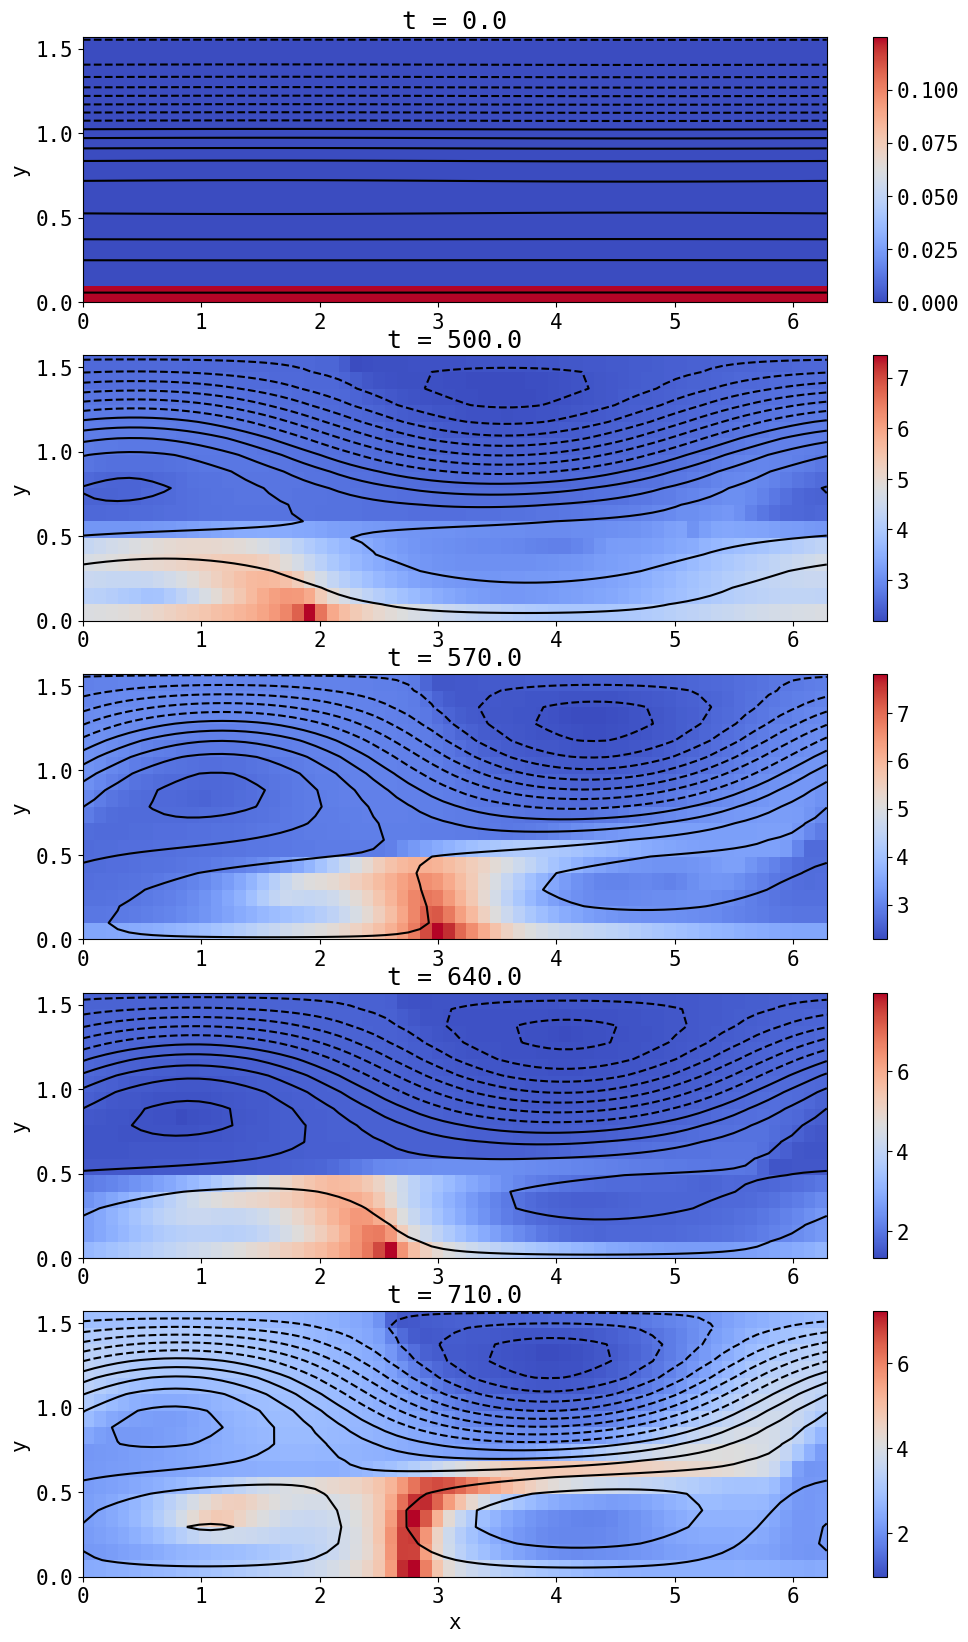

In [73]:
Xs,Ys = np.meshgrid(x_s,y_s,indexing='ij')
Xc,Yc = np.meshgrid(
    np.linspace(0,2*np.pi,cfg['Nxfv']+1), 
    np.linspace(0,np.pi*cfg['b'],cfg['Nyfv']+1),
    indexing='ij'
)

fig,axes = plt.subplots(figsize=(12,4*len(tps2plot)), nrows=Nt2plot)
for (i_tp,tp) in enumerate(tps2plot):
    ax = axes[i_tp]
    i_t = np.argmin(np.abs(tp - tp_ctrl))
    img = ax.pcolormesh(Xc,Yc,conc_ctrl[i_t],cmap='coolwarm')
    ax.contour(Xs,Ys,sf_ctrl[i_t],colors='black',levels=15)
    fig.colorbar(img, ax=ax, orientation='vertical')
    if i_tp == Nt2plot-1: ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(f"t = {tp}")

Exercise: plot timeseries of concentrations in some selected grid boxes. See how it tracks with the pictures. Plot PDFs. 

# Perturb the model before extreme events

Select a target location (in practice, do this based on GPD statistics)

In [74]:

x_target = 3.9 #Lx * ()
y_target = 0.5 #Ly * ()
ix_target = int(x_target/dx)
iy_target = int(y_target/dy)


Examine the timeseries of concentrations there

$\cos(\omega t)$ has a period of $T=2\pi/\omega$, so to make a cosine with period $T$, you would write $\cos(2\pi t/T)$

Text(0, 0.5, 'Bottom source')

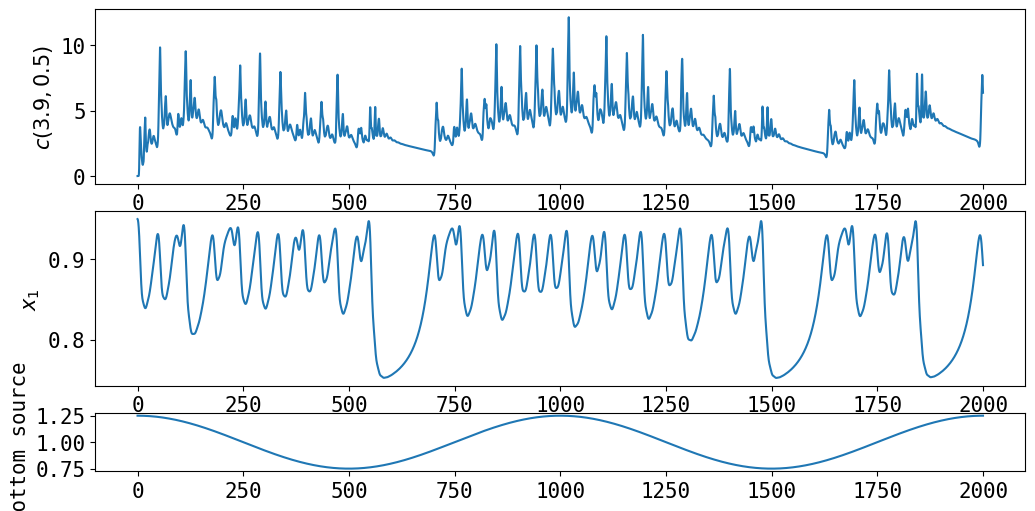

In [75]:
tidx = np.arange(max(0,Nt-20000),Nt)
fig,axes = plt.subplots(nrows=3,ncols=1,figsize=(12,6),height_ratios=[3,3,1])
ax = axes[0]
ax.plot(tp_ctrl[tidx], conc_ctrl[tidx,ix_target,iy_target])
ax.set_ylabel(r'$c(%.1f,%.1f)$'%(x_target,y_target))
ax = axes[1]
ax.plot(tp_ctrl[tidx], state_ctrl[tidx,0])
ax.set_ylabel(r'Mean flow')
ax = axes[2]
ax = axes[2]
ax.plot(tp_ctrl[tidx], crom.source_mean + crom.source_amplitude * np.cos(2*np.pi*tp_ctrl[tidx]/crom.source_period)) 
ax.set_ylabel("Bottom source")

Assignment: look at the snapshots of the velocity field during "droughts" and try to explain physically why a drought happened there

Possible investigation: how does the phase (season) of the bottom source affect the probability to have spikes of a certain magnitude? (i.e., is precipitation more extreme in the summer?)
Is there a correlation between the peak magnitudes and the phase? 
(and repeat this for various amplitudes, periods, etc.) 

In [88]:
it_target = np.argmax(conc_ctrl[:,ix_target,iy_target])
tp_target = tp_ctrl[it_target]
dtp_lead = 50.0
dtp_follow = 30.0 
tp_init_pert = tp_target-dtp_lead
tp_term_pert = tp_target + dtp_follow
t_init_pert = int(round(tp_init_pert/crom.dt_save))
t_term_pert = int(round(tp_term_pert/crom.dt_save))
t_pert = np.arange(t_init_pert+1, t_term_pert+1, dtype=int)
tp_pert = t_pert * crom.dt_save



it_pert = it_target - int(round(dtp_lead/crom.dt_save))


In [89]:
rng = np.random.default_rng(78291)

In [98]:
# perturb the first mode
pert_rel_mag = 0.01
modes2perturb = np.array([3]) # anything from 0 to 5
state_init_pert = np.copy(state_ctrl[it_pert])
state_init_pert[modes2perturb] *= (1 + pert_rel_mag * rng.normal(len(modes2perturb)))
state_pert = np.zeros((len(t_pert),crom.state_dim))
integration_fun = getattr(crom, f'integrate_{cfg["timestepper"]}')
integration_fun(state_pert, tp_pert, t_init_pert, state_init_pert) # mutating function 
tspan_str = (f't{tp_init_pert}-{tp_term_pert}').replace('.','p')
traj_file_pert = join(savedir,f'history_pert_{tspan_str}.npz')
np.savez(traj_file_pert, **{'t': t_pert, 'state': state_pert})

### params2vary
- magnitude of perturbation (pert_rel_mag)
- dtp_lead (and maybe dtp_follow)
- mode2perturb
- which peak to boost

Another exploratory question: how boostable is a peak, as a function of its magnitude?

(950.1, 1070.1)

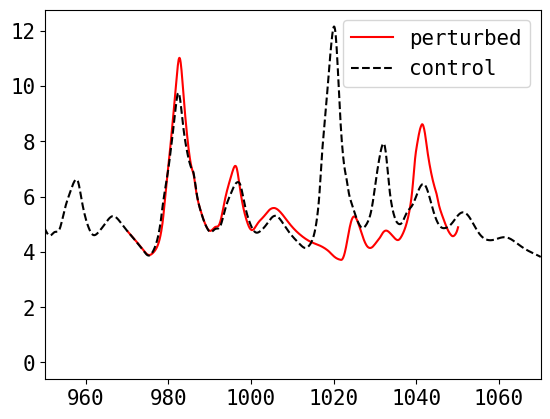

In [99]:
conc_pert = conc_fun(state_pert)
fig,ax = plt.subplots()
hpert, = ax.plot(tp_pert, conc_pert[:,ix_target,iy_target], color='red', label='perturbed')
hctrl, = ax.plot(tp_ctrl, conc_ctrl[:,ix_target,iy_target], color='black', linestyle='--', label='control')
ax.legend(handles=[hpert,hctrl])
ax.set_xlim([tp_init_pert-20,tp_term_pert+20])